# Wprowadzenie do sieci neuronowych i uczenia maszynowego

## Lab: Własne moduły w PyTorch, regularyzacja i autoenkodery

---

**Autorzy materiałów:** Marek Wydmuch, Iwo Błądek, Jakub Bednarek<br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

- zapoznanie się z tworzeniem własnych modułów w PyTorch
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [1]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Własne moduły (warstwy sieci neuronowych) w PyTorch



Na poprzednich zajęciach używaliśmy gotowych modułów reprezentujących warstwy sieci neuronowych by stworzyć główny moduł naszego modułu.

W PyTorch nie ma żadnej hierarchii modułów (jak np. w TensorFlow czy Keras, gdzie API jest podzielone na modele i warstwy). Każdy moduł może używać innych modułów jako swoich komponentów.

Poniżej przykładowa implementacja modułu warstwy liniowej całkowicie od podstaw.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer, self).__init__()
        # Parametry (wagi) naszego modułu
        self.weights = nn.Parameter(torch.Tensor(input_dim, output_dim))
        # Inicjalizacja wag
        nn.init.xavier_normal_(self.weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.mm(x, self.weights)

class CustomModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.layers = nn.Sequential(
            CustomLayer(784, 512),
            nn.ReLU(),
            CustomLayer(512, 512),
            nn.ReLU(),
            CustomLayer(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
# Setup naszego modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CustomModel(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

def accuracy(pred, target):
    return (pred.argmax(1) == target).type(torch.float).sum().item()

# Pętla treningowa i testowa
def train_and_test(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        metric=None,
        epochs=10,
        verbose=False
    ):
    epochs_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * data.size(0)
            train_metric += metric(pred, target)
        if verbose:
            train_loss /= len(train_loader.dataset)
            train_metric /= len(train_loader.dataset)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Train {metric.__name__}: {train_metric:.4f}")

        model.eval()
        test_metric = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_metric += metric(pred, target)
        if verbose:
            test_loss /= len(test_loader.dataset)
            test_metric /= len(test_loader.dataset)
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {test_metric:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          f"train_{metric.__name__}": train_metric,
          "test_loss": test_loss,
          f"test_{metric.__name__}": test_metric
        })
    return epochs_history

_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Using device: cuda
Epoch: 0, Batch: 0, Loss: 2.3047
Epoch: 0, Batch: 100, Loss: 1.5124
Epoch: 0, Batch: 200, Loss: 1.5149
Epoch: 0, Batch: 300, Loss: 1.5435
Epoch: 0, Batch: 400, Loss: 1.5372
Train loss: 1.5583
Train accuracy: 0.9114
Test loss: 1.5046
Test accuracy: 0.9589
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4723
Epoch: 1, Batch: 100, Loss: 1.4913
Epoch: 1, Batch: 200, Loss: 1.4980
Epoch: 1, Batch: 300, Loss: 1.4966
Epoch: 1, Batch: 400, Loss: 1.5011
Train loss: 1.5028
Train accuracy: 0.9604
Test loss: 1.4985
Test accuracy: 0.9636
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4953
Epoch: 2, Batch: 100, Loss: 1.4907
Epoch: 2, Batch: 200, Loss: 1.4770
Epoch: 2, Batch: 300, Loss: 1.5104
Epoch: 2, Batch: 400, Loss: 1.4925
Train loss: 1.4933
Train accuracy: 0.9691
Test loss: 1.4928
Test accuracy: 0.9690
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4951
Epoch: 3, Batch: 100, Loss: 1.5086
Epoch: 3, Batch: 200, Loss: 1.4791
Epoch: 3, Batch: 

### Zadanie 1

Stwórz prosty model
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `nn.Flatten`.

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features = 64 * 14 * 14, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              # BatchNorm: weight = 1, bias = 0
              if m.weight is not None:
                  nn.init.constant_(m.weight, 1)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Dropout):
              # Dropout nie ma parametrów do inicjalizacji
              pass

    def forward(self, x):
        return self.layers(x)


## Zadanie 2

Na podstawie powyższego przykładu stwórz moduł bloku ResNet.
Zadbaj o to by rozmiary tensorów po warstwach konwolucyjnych się nie zmieniały.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet.



In [6]:
class ResidualLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResidualLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_dim, out_channels=output_dim, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=output_dim, out_channels=output_dim, kernel_size=3, padding="same")
        # Jeśli liczba kanałów wejściowych różni się od liczby kanałów wyjściowych,
        # dodajemy warstwę projekcji (1x1 Conv), aby zmienić liczbę kanałów w wejściu
        if input_dim != output_dim:
            self.projection = nn.Conv2d(in_channels=input_dim, out_channels=output_dim, kernel_size=1, stride=1, padding=0)
        else:
            self.projection = None
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        input = x
        out1 = self.conv1(x)
        out1 = self.relu(out1)
        out2 = self.conv2(out1)
        # Jeśli liczba kanałów wejściowych różni się od liczby kanałów wyjściowych,
        # to używamy warstwy projekcji, aby dostosować rozmiar wejścia
        if input.shape[1] != out2.shape[1]:
            if self.projection:
                input = self.projection(input)  # Zmienia liczbę kanałów w wejściu
            else:
                # Jeśli liczba kanałów jest już zgodna, po prostu kopiujemy wejście
                input = input
        out2 += input
        out2 = self.relu(out2)
        return out2

class SimpleModel2(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel2, self).__init__()
        self.layers = nn.Sequential(
            ResidualLayer(1, 32),
            ResidualLayer(32,64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features = 64 * 14 * 14, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              # BatchNorm: weight = 1, bias = 0
              if m.weight is not None:
                  nn.init.constant_(m.weight, 1)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Dropout):
              # Dropout nie ma parametrów do inicjalizacji
              pass

    def forward(self, x):
        return self.layers(x)


## Regularyzacja

### Zadanie 3

Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (nn.Dropout):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.
- dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [7]:
class SimpleModel3(nn.Module):
    def __init__(self, num_classes=10, use_dropout=True):
        super(SimpleModel3, self).__init__()
        self.use_dropout = use_dropout
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25) if use_dropout else nn.Identity(),
            nn.Flatten(),
            nn.Linear(in_features=64*14*14, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              # BatchNorm: weight = 1, bias = 0
              if m.weight is not None:
                  nn.init.constant_(m.weight, 1)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Dropout):
              # Dropout nie ma parametrów do inicjalizacji
              pass

    def forward(self, x):
        return self.layers(x)


### Zadanie 4
Rozszerz model stworzony w poprzednich zadaniach o dwie warstwy Batch normalization (nn.BatchNorm2d) po warstwach konwolucyjnych. Dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [8]:
class SimpleModel4(nn.Module):
    def __init__(self, num_classes=10, use_dropout=True):
        super(SimpleModel4, self).__init__()
        self.use_dropout = use_dropout
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32, eps=1e-3, momentum=0.5),  # Dostosowane parametry
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64, eps=1e-3, momentum=0.5),  # Dostosowane parametry
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25) if use_dropout else nn.Identity(),
            nn.Flatten(),
            nn.Linear(in_features=64*14*14, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()
    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              # BatchNorm: weight = 1, bias = 0
              if m.weight is not None:
                  nn.init.constant_(m.weight, 1)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Dropout):
              # Dropout nie ma parametrów do inicjalizacji
              pass

    def forward(self, x):
        return self.layers(x)


### Zadanie 5
Porównaj model bez oraz z różnych kombinacjami technik regularyzacji (z dropoutem ale bez batch norm., bez dropout ale z batch norm., z dropoutem i z batch norm.).
Stwórz cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego.

Training Plain Model...
Epoch: 0, Batch: 0, Loss: 2.3023
Epoch: 0, Batch: 100, Loss: 1.5417
Epoch: 0, Batch: 200, Loss: 1.4768
Epoch: 0, Batch: 300, Loss: 1.4731
Epoch: 0, Batch: 400, Loss: 1.4692
Train loss: 1.5291
Train accuracy: 0.9355
Test loss: 1.4858
Test accuracy: 0.9771
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4805
Epoch: 1, Batch: 100, Loss: 1.4916
Epoch: 1, Batch: 200, Loss: 1.4778
Epoch: 1, Batch: 300, Loss: 1.5025
Epoch: 1, Batch: 400, Loss: 1.4843
Train loss: 1.4858
Train accuracy: 0.9760
Test loss: 1.4806
Test accuracy: 0.9810
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4614
Epoch: 2, Batch: 100, Loss: 1.4686
Epoch: 2, Batch: 200, Loss: 1.4923
Epoch: 2, Batch: 300, Loss: 1.4865
Epoch: 2, Batch: 400, Loss: 1.4690
Train loss: 1.4796
Train accuracy: 0.9820
Test loss: 1.4871
Test accuracy: 0.9752
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4721
Epoch: 3, Batch: 100, Loss: 1.4959
Epoch: 3, Batch: 200, Loss: 1.4920
Epoch: 3, Ba

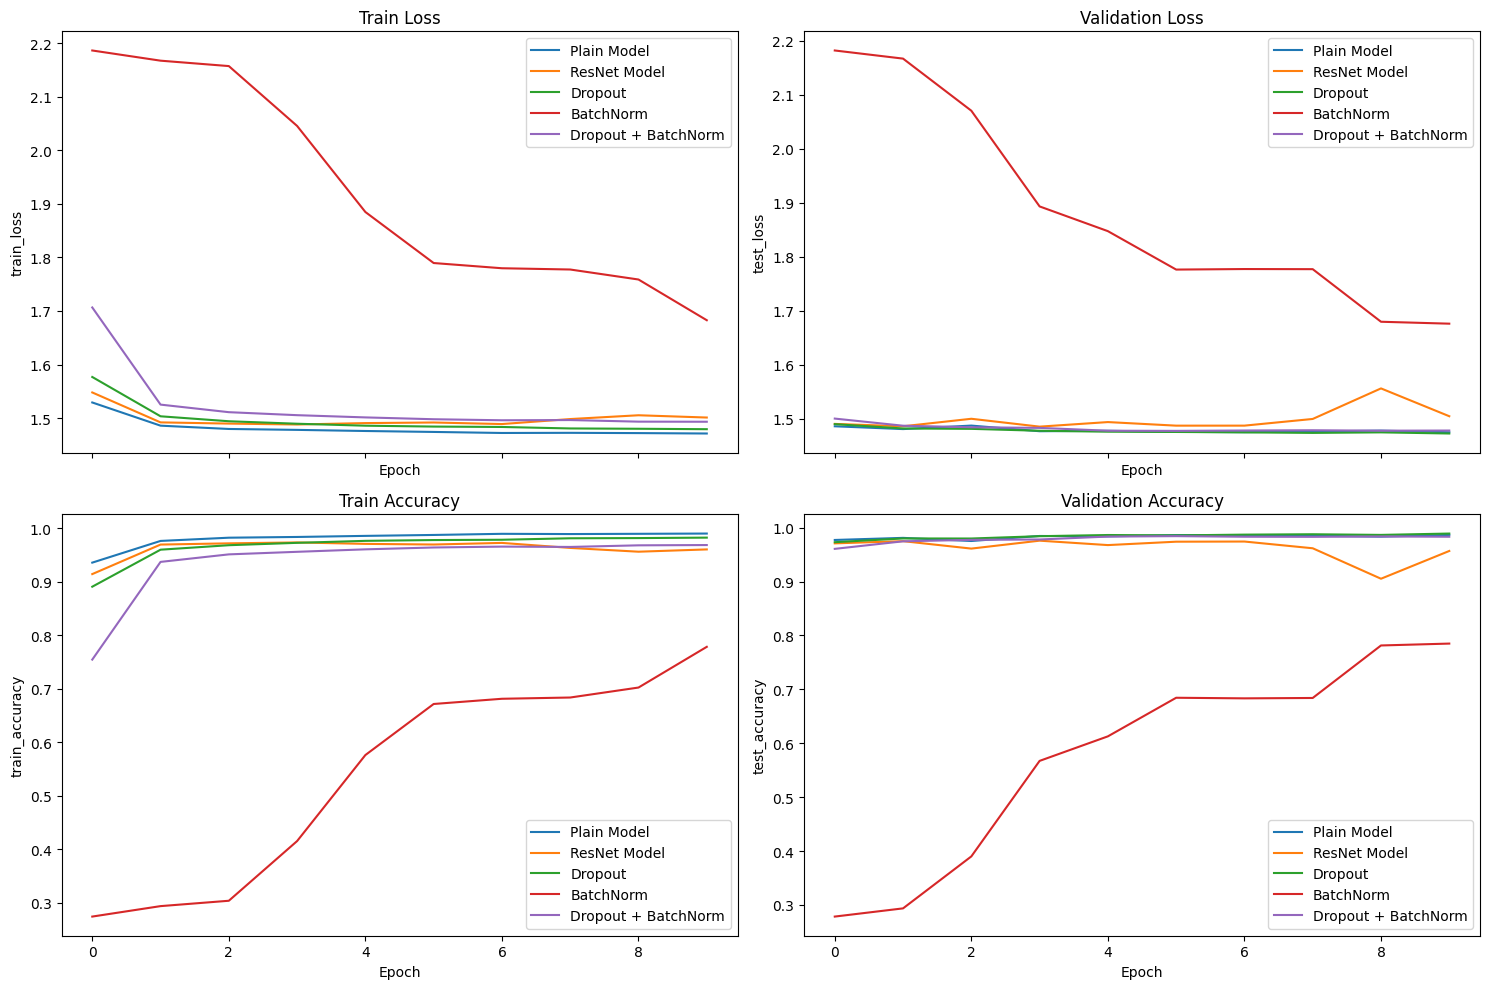

In [9]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "Plain Model": SimpleModel(num_classes=10).to(device),
    "ResNet Model": SimpleModel2(num_classes=10).to(device),
    "Dropout": SimpleModel3(num_classes=10).to(device),
    "BatchNorm": SimpleModel4(num_classes=10, use_dropout=False).to(device),
    "Dropout + BatchNorm": SimpleModel4(num_classes=10, use_dropout=True).to(device)
}

criterion = nn.CrossEntropyLoss()
optimizer_configs = {name: optim.Adam(model.parameters()) for name, model in models.items()}
histories = {}

for name, model in models.items():
    print(f"Training {name}...")
    optimizer = optimizer_configs[name]
    histories[name] = train_and_test(
        train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True
    )

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
metrics = ['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy']
titles = [
    "Train Loss", "Validation Loss", "Train Accuracy", "Validation Accuracy"
]

for i, (ax, metric, title) in enumerate(zip(axs.flatten(), metrics, titles)):
    for name, history in histories.items():
        values = [epoch[metric] for epoch in history]
        ax.plot(values, label=name)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.show()


## Autoenkodery

Ideę autoenkodera prezentuje poniższy rysunek:
![label-autoencoder_schema](https://drive.google.com/uc?export=view&id=1Ai2ER1ppKfnHg5t_lCwO_fvvFNe59dgd)

Widzimy tutaj, że obrazek ze zbioru MNIST o rozmiarze 28 x 28 został skompresowany przez **enkoder** do tensora o rozmiarze 4 x 2. Tensor ten nosi nazwę **wektora zmiennych ukrytych** (ang. latent vector). Następnie **dekoder** przyjął ten wektor na wejście, i odtworzył oryginalny obrazek. Jest to przykład zadania **autoasocjacji**, gdzie celem uczenia sieci neuronowej jest możliwie wierne odtworzenie danych wejściowych. Zadanie to może się wydawać bez sensu w odosobnieniu (po co odtwarzać coś, co już mamy?), jednak to co nas najbardziej interesuje w autoenkoderze to wektor zmiennych ukrytych. Jako że skompresowaliśmy cały obrazek do 8 wartości, to by realistyczne odtworzenie z nich oryginalnego obrazka było możliwe, każda z tych wartości musi 1) zawierać o nim możliwie dużo informacji, 2) nieistotne detale oryginalnego obrazka muszą zostać pominięte. Wyciągnęliśmy więc z danych informacyjną "esencję", pozbyliśmy się redundatnych elementów opisu.

<br>

Najważniejszą cechą autoenkodera jest właśnie **uczenie się efektywnego kodowania danych**, co zazwyczaj wiąże się z redukcją wymiarowości (tzw. 'undercomplete autoencoders'), choć można też uczyć autoenkodery o kodowaniu zwiększającym wymiarowość (tzw. 'overcomplete autoencoders'). Skupimy się na autoenkoderach zmniejszających wymiarowość, bo ich uczenie jest znacznie prostsze. W przeciwieństwie do np. PCA kodowanie uzyskane przez taki autoenkoder może być nieliniowe, tak więc zmienne ukryte mają więcej elastyczności w reprezentacji danych. Selekcja atrybutów, której podstawy omawialiśmy wcześniej na przedmiocie, również redukuje wymiarowość, ale nie zmienia informacji w atrybutach. W ogólności techniki redukcji wymiarowości tworzą zupełnie nowe atrybuty ze starych (np. $Y_1 = 0.5X_1 - 0.25X_2^2 + \log_2 X_3$, gdzie $Y_1$ to nowy atrybut, a $X_i$ to oryginalne atrybuty). Wiele zastosowań autoenkoderów buduje właśnie na tej zdolności, a także na tym, że dzięki procesowi uczenia sieci tworzymy metodę redukcji wymiarowości zoptymalizowaną do konkretnego problemu.

<br>

Autoenkodery mają wiele potencjalnych zastosowań, przykładowo:
* Redukcja wymiarowości - uczymy autoenkoder w trybie autoasocjacji, i naszym celem jest zmniejszenie wymiarowości danych, czyli zastąpienie oryginalnego obiektu jego wektorem zmiennych ukrytych. Można użyć jako alternatywy dla selekcji atrybutów i dedykowanych metod redukcji wymiarowości (PCA, LDA, etc.).
* Grupowanie - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektory zmiennych ukrytych uzyskane dla danych uczących jako wejście do algorytmu grupowania (np. k-means).
* Wyszukiwanie informacji - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektor zmiennych ukrytych jako hasz obiektu. Jeżeli chcemy znaleźć w bazie danych obiekty podobne do zadanego obiektu $X$, to generujemy wektor zmiennych ukrytych (hasz) $X$ przy użyciu enkodera i szukamy obiektów w zbiorze o najbardziej zbliżonych haszach. Technika ta nazywana jest haszowaniem semantycznym.
* Wykrywanie anomalii - uczymy autoenkoder w trybie autoasocjacji wyłącznie na przypadkach "normalnych". Liczymy na to, że jak kiedykolwiek autoenkoder dostanie do przetworzenia przypadek odstający/anomalię, to nie da rady jej dobrze zrekonstruować (właśnie przez to, że nie miał szansy się na nich nauczyć).
* Generowanie danych - uczymy autoenkoder w trybie autoasocjacji, a następnie jak chcemy uzyskać różne warianty danego obrazu/obiektu, to modyfikujemy jego wygenerowany przez enkoder wektor zmiennych ukrytych, i dajemy go do przetworzenia dekoderowi. Możemy też po prostu losowo próbkować przestrzeń wektorów ukrytych i obserwować wyniki po przetworzeniu przez dekoder. Przy odrobinie szczęścia jakaś zmienna ukryta może np. odpowiadać za wyraz twarzy człowieka, i zmieniając wartości tej zmiennej możemy zmieniać wyłącznie wyraz twarzy człowieka na zdjęciu. Do tego zadania zazwyczaj wykorzystywany jest zmodyfikowany wariant autoenkodera: autoenkoder wariacyjny.
* Odszumianie - uczymy autoenkoder w trybie heteroasocjacji: *zaszumiony obraz* -> *oryginalny obraz*. Liczymy na to, że enkoder i dekoder nauczą się poprawnie rozpoznawać szum jako element redundantny, nieniosący żadnej informacji.<br>
![label-autoencoder_denoising](https://drive.google.com/uc?export=view&id=1a1fP7CWjzKSwo0txUBUMwaxTrpt6LzyH)



### Zadanie 6

Zaimplementuj autoenkoder o następującej architekturze:
* Enkoder: Dense(100) -> Dense(50) -> Dense(10) (wektor zmiennych ukrytych).
* Dekoder: Dense (50) -> Dense(100) -> Dense(784) (wyjściowy zrekonstruowany obrazek)

Funkcję aktywacji ustaw jako 'relu'. Jako miara błędu użyte zostanie MSE.

Epoch: 0, Batch: 0, Loss: 0.1110
Epoch: 0, Batch: 100, Loss: 0.0466
Epoch: 0, Batch: 200, Loss: 0.0399
Epoch: 0, Batch: 300, Loss: 0.0349
Epoch: 0, Batch: 400, Loss: 0.0352
Train loss: 0.0423
Train pixel_accuracy: 0.8871
Test loss: 0.0325
Test accuracy: 0.9026
-------------------------------
Epoch: 1, Batch: 0, Loss: 0.0325
Epoch: 1, Batch: 100, Loss: 0.0326
Epoch: 1, Batch: 200, Loss: 0.0291
Epoch: 1, Batch: 300, Loss: 0.0300
Epoch: 1, Batch: 400, Loss: 0.0319
Train loss: 0.0308
Train pixel_accuracy: 0.9057
Test loss: 0.0290
Test accuracy: 0.9094
-------------------------------
Epoch: 2, Batch: 0, Loss: 0.0283
Epoch: 2, Batch: 100, Loss: 0.0275
Epoch: 2, Batch: 200, Loss: 0.0290
Epoch: 2, Batch: 300, Loss: 0.0274
Epoch: 2, Batch: 400, Loss: 0.0287
Train loss: 0.0284
Train pixel_accuracy: 0.9108
Test loss: 0.0275
Test accuracy: 0.9129
-------------------------------
Epoch: 3, Batch: 0, Loss: 0.0285
Epoch: 3, Batch: 100, Loss: 0.0268
Epoch: 3, Batch: 200, Loss: 0.0275
Epoch: 3, Batch: 3

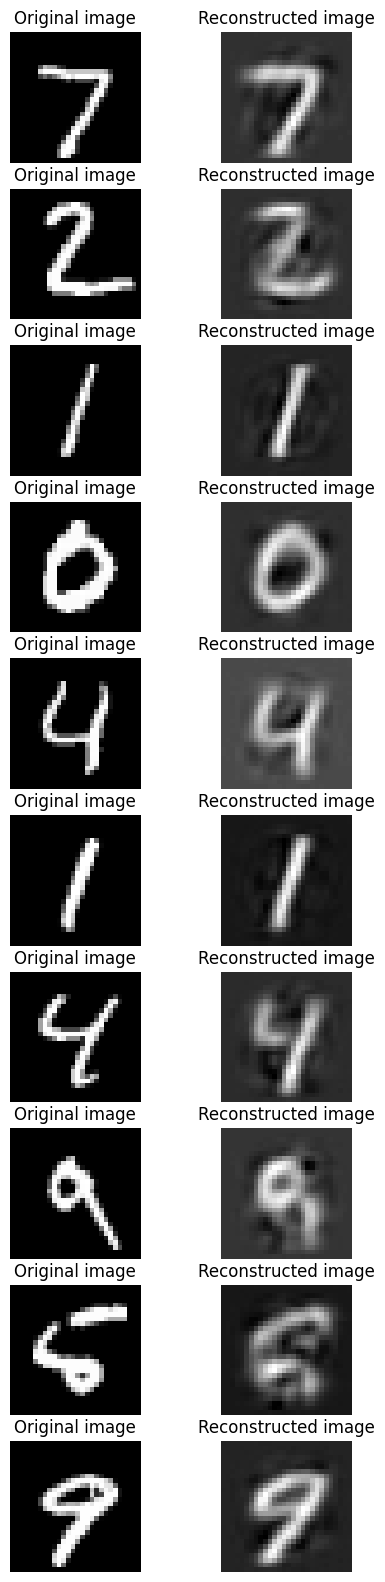

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=10, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=784),
        )

        self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              # BatchNorm: weight = 1, bias = 0
              if m.weight is not None:
                  nn.init.constant_(m.weight, 1)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Dropout):
              # Dropout nie ma parametrów do inicjalizacji
              pass

    def forward(self, x):
        # Ensure input is flattened
        x = x.view(-1, 784).to(device)
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        # Reshape back to 1x28x28
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

class AutoencoderDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, _ = self.dataset[idx]
        return data, data  # Target to kopia wejścia

train_Autoencoder_loader = DataLoader(AutoencoderDataset(train_data), batch_size=128, shuffle=True)
test_Autoencoder_loader = DataLoader(AutoencoderDataset(test_data), batch_size=128, shuffle=False)

def visualize_reconstruction(model, test_loader, num_images=10):
    model.eval()
    data_iter = iter(test_loader)
    images, _ = next(data_iter)

    # Przenieś obrazy na odpowiednie urządzenie (GPU lub CPU)
    images = images[:num_images].to(device)

    with torch.no_grad():
        reconstructed = model(images)

    # Upewnij się, że zarówno obrazy, jak i zrekonstruowane obrazy są na CPU
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(num_images, 2, figsize=(5, num_images * 2))
    for i in range(num_images):
        ax = axes[i, 0]
        ax.imshow(images[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Original image")
        ax.axis('off')

        ax = axes[i, 1]
        ax.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        ax.set_title(f"Reconstructed image")
        ax.axis('off')

    plt.show()

def pixel_accuracy(pred, target):
    diff = torch.abs(pred - target)
    accuracy_per_image = diff.mean(dim=[1, 2, 3])
    total_loss = accuracy_per_image.sum().item()# Suma średnich różnic dla każdego obrazu w batchu
    batch_size = pred.size(0)
    return (batch_size-total_loss)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 20
_ = train_and_test(train_Autoencoder_loader, test_Autoencoder_loader, model, optimizer, criterion, metric=pixel_accuracy, epochs=epochs, verbose=True)

visualize_reconstruction(model, test_loader, 10)

### Zadanie 7

Użyj zaimplementowanego wyżej autoenkodera by zaobserwować jak zmienia się odtwarzany obraz gdy zmienia się tylko jeden element wektora zmiennych ukrytych. Zadanie wykonywane jest w następujących krokach:
1. Użyj nauczonego enkodera z poprzedniego zadania na przypadku uczącym wybranej cyfry (dowolnej) by uzyskać wektor zmiennych ukrytych.
2. Wybierz konkretną zmienną ukrytą w tym wektorze, np. tę o indeksie 0.
3. W pętli podstawiaj różne wartości do tej zmiennej wektora z pewnym krokiem, i obserwuj obrazki generowane przez dekoder. Sugestia: tworząc zakres wartości do iteracji warto wykorzystać minimalną i maksymalną wartość danej zmiennej ukrytej - gwarantuje to zauważalne różnice na dekodowanych obrazach.

Original image


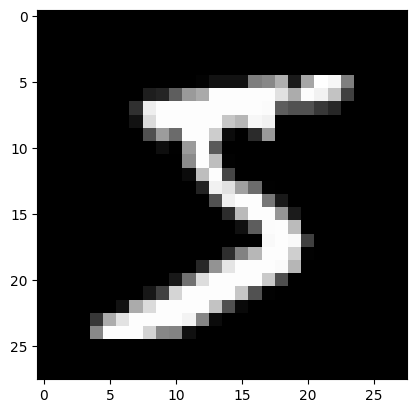

Reconstructed image


<ipython-input-11-8e08ee42ee5c>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(example, dtype=torch.float32).unsqueeze(0).to(device)  # Zamienia na tensor i dodaje wymiar batcha (dim=0)


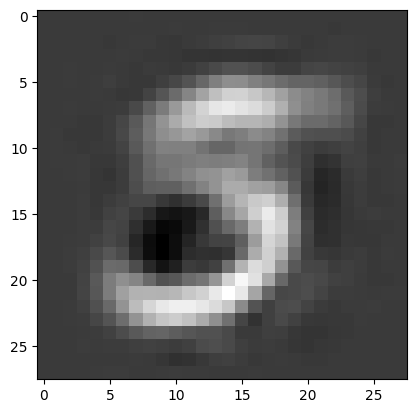

latent_vector: tensor([[5.9466, 0.0000, 3.4213, 3.6232, 6.0328, 3.1522, 2.7010, 3.9892, 0.9714,
         1.2617]], device='cuda:0', grad_fn=<ReluBackward0>)
e: 0.0


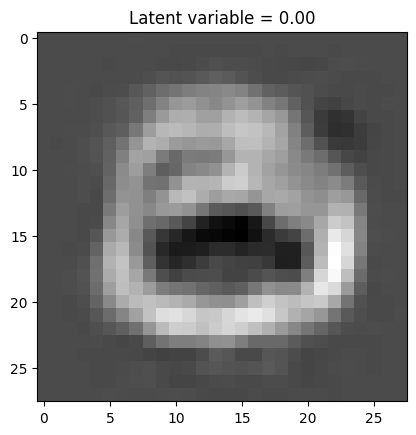

e: 0.6032791614532471


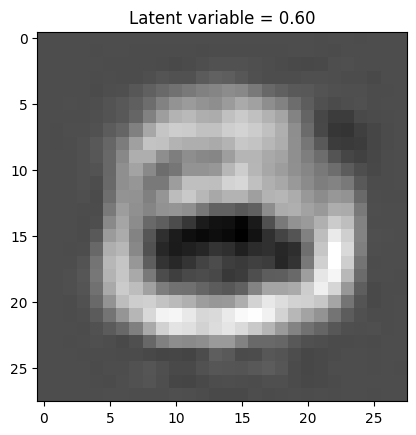

e: 1.2065583229064942


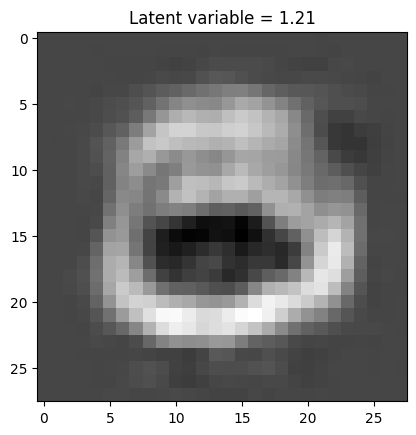

e: 1.8098374843597413


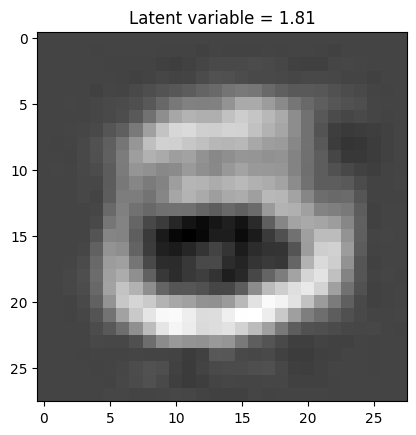

e: 2.4131166458129885


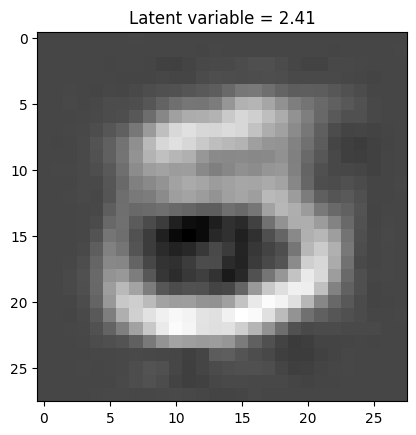

e: 3.0163958072662354


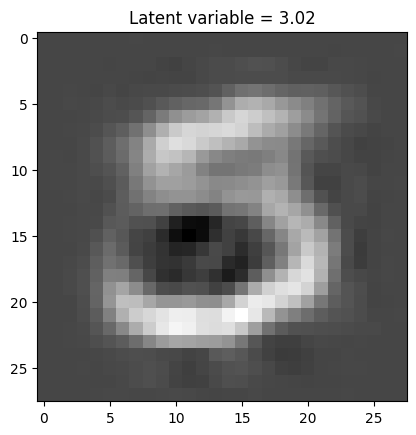

e: 3.6196749687194827


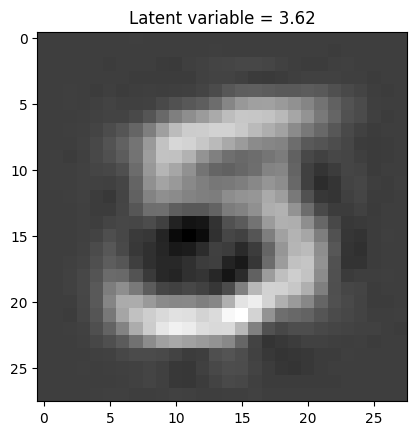

e: 4.22295413017273


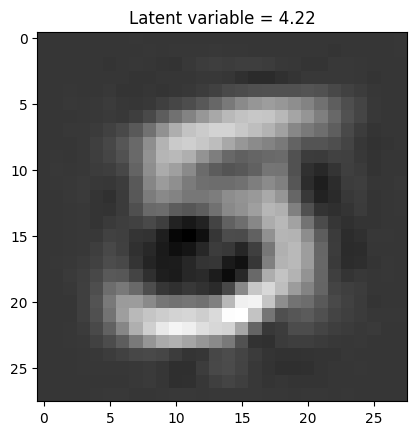

e: 4.826233291625977


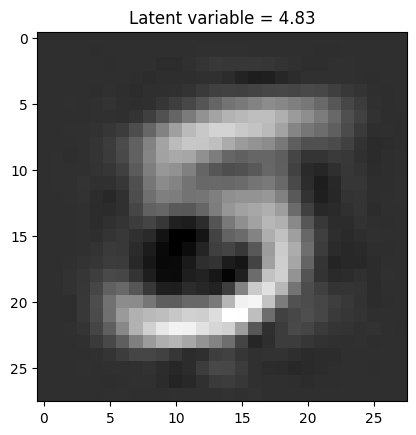

e: 5.429512453079224


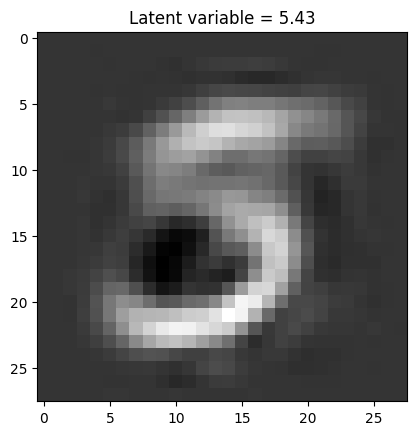

e: 6.032791614532471


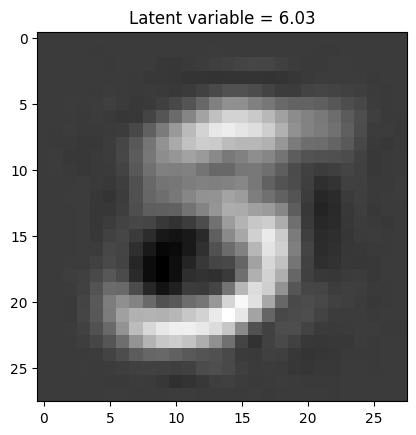

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

example = train_data[0][0]

print("Original image")
plt.imshow(example.reshape((28, 28)), cmap='gray')
plt.show()

x = torch.tensor(example, dtype=torch.float32).unsqueeze(0).to(device)  # Zamienia na tensor i dodaje wymiar batcha (dim=0)

# Po uczeniu wykonanym w poprzednim zadaniu, mamy dostęp do już nauczonych składowych sieci
x = x.view(-1, 784)

latent_vector = model.encoder(x)
output = model.decoder(latent_vector)

print("Reconstructed image")
plt.imshow(output.view(28, 28).detach().cpu().numpy(), cmap='gray')
plt.show()

print(f"latent_vector: {latent_vector}")

# Zmiana jednej zmiennej w wektorze zmiennych ukrytych i obserwacja efektów
for e in np.linspace(latent_vector.min().item(), latent_vector.max().item(), 11):
    print(f"e: {e}")

    latent_vector_copy = latent_vector.clone()
    latent_vector_copy[0, 0] = e
    new_output = model.decoder(latent_vector_copy)

    plt.imshow(new_output.view(28, 28).detach().cpu().numpy(), cmap='gray')  # Detach i konwersja na NumPy do wyświetlenia
    plt.title(f"Latent variable = {e:.2f}")
    plt.show()


### Zadanie 8

Wykorzystaj kod z poprzednich zadań by nauczyć autoenkoder odszumiania. Parę uwag:
* Musisz zmodyfikować zbiór uczący poprzez dodanie sztucznego szumu. Można to zrobić albo poprzez zmianę wartości kilku losowych pikseli w każdym obrazku, albo dodanie macierzy z małymi losowo generowanymi liczbami do obrazka (do każdego obrazka innej!). Oczekiwaną odpowiedzą podczas uczenia będzie oryginalny obrazek bez szumu.
* Architektura enkodera i dekodera może pozostać bez zmian, ale będziesz musiał ją ponownie nauczyć, tak więc by nie psuć wyników z zadania nr 1 sugeruję przeklejenie odpowiedniego kodu tutaj.
* Zademonstruj działanie odszumiania poprzez pokazanie przypadku z szumem, a następnie zrekonstruowanego obrazka bez szumu po przetworzeniu przez autoenkoder.

Epoch: 0, Batch: 0, Loss: 0.1234
Epoch: 0, Batch: 100, Loss: 0.0555
Epoch: 0, Batch: 200, Loss: 0.0402
Epoch: 0, Batch: 300, Loss: 0.0384
Epoch: 0, Batch: 400, Loss: 0.0338
Train loss: 0.0454
Train pixel_accuracy: 0.8828
Test loss: 0.0337
Test accuracy: 0.9010
-------------------------------
Epoch: 1, Batch: 0, Loss: 0.0337
Epoch: 1, Batch: 100, Loss: 0.0333
Epoch: 1, Batch: 200, Loss: 0.0303
Epoch: 1, Batch: 300, Loss: 0.0320
Epoch: 1, Batch: 400, Loss: 0.0311
Train loss: 0.0317
Train pixel_accuracy: 0.9048
Test loss: 0.0294
Test accuracy: 0.9092
-------------------------------
Epoch: 2, Batch: 0, Loss: 0.0315
Epoch: 2, Batch: 100, Loss: 0.0304
Epoch: 2, Batch: 200, Loss: 0.0277
Epoch: 2, Batch: 300, Loss: 0.0283
Epoch: 2, Batch: 400, Loss: 0.0265
Train loss: 0.0283
Train pixel_accuracy: 0.9112
Test loss: 0.0267
Test accuracy: 0.9136
-------------------------------
Epoch: 3, Batch: 0, Loss: 0.0282
Epoch: 3, Batch: 100, Loss: 0.0257
Epoch: 3, Batch: 200, Loss: 0.0276
Epoch: 3, Batch: 3

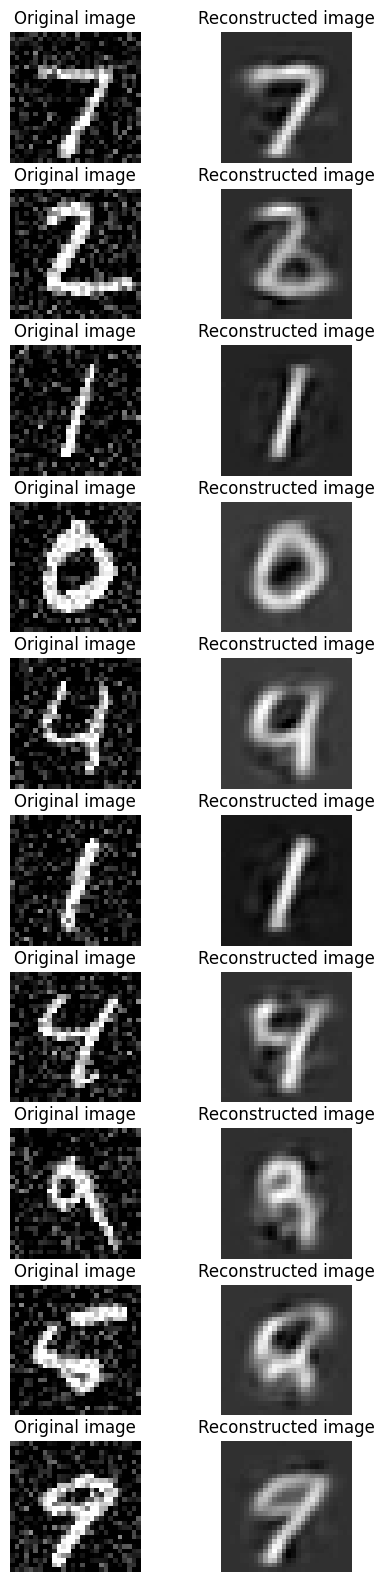

In [14]:
import torch
import torch.nn as nn
import torch.nn.init as init

class NoiseRemover(nn.Module):
    def __init__(self):
        super(NoiseRemover, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=10, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=784),
        )

        self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              # BatchNorm: weight = 1, bias = 0
              if m.weight is not None:
                  nn.init.constant_(m.weight, 1)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Dropout):
              # Dropout nie ma parametrów do inicjalizacji
              pass

    def forward(self, x):
        # Ensure input is flattened
        x = x.view(-1, 784)
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        # Reshape back to 1x28x28
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

class NoiseRemoverDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_factor=0.2):
        self.dataset = dataset
        self.noise_factor = noise_factor  # Określa intensywność szumu

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, _ = self.dataset[idx]
        noisy_data = self.add_noise(data)
        return noisy_data, data  # obraz z szumem jako dane wejściowe, oryginalny obraz jako cel

    def add_noise(self, image):
        noise = torch.randn_like(image) * self.noise_factor
        noisy_image = image + noise
        noisy_image = torch.clamp(noisy_image, 0., 1.)
        return noisy_image

train_NoiseRemover_loader = DataLoader(NoiseRemoverDataset(train_data), batch_size=128, shuffle=True)
test_NoiseRemover_loader = DataLoader(NoiseRemoverDataset(test_data), batch_size=128, shuffle=False)


noiseRemover = NoiseRemover().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(noiseRemover.parameters())
epochs = 20
_ = train_and_test(train_NoiseRemover_loader, test_NoiseRemover_loader, noiseRemover, optimizer, criterion, metric=pixel_accuracy, epochs=epochs, verbose=True)

visualize_reconstruction(noiseRemover, test_NoiseRemover_loader, 10)